<a href="https://colab.research.google.com/github/Ddongh/HTMLproject/blob/main/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EC%A3%BC%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [454]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

import time

In [455]:
import pandas_datareader as pdr # 주식데이터 크롤링

from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error #MAE

In [456]:
# 실행 오류 발생시

# 1. pandas, pandas-datareader 업그레이드
# pip install --upgrade pandas
# pip install --upgrade pandas-datareader 

# 2. 런타임 초기화
# 메뉴의 '런타임'-'런타임 초기화'

In [457]:
pip install --upgrade pandas

In [458]:
pip install --upgrade pandas-datareader

In [459]:
code = '005930.KS' # 사용자로부터 종목코드를 받음
start = '2020-01-01' # 
end='2020-06-30'

def rnn(code, start, end): # 순환신경망(RNN)분석
    df = pdr.get_data_yahoo(code, start=start, end=end).reset_index()  # 주식 데이터 크롤링
    dataset = df['Close'].values # 종가 데이터 추출
    dataset = dataset.reshape(dataset.shape[0], 1) # 1차원배열을 2차원으로 변경
    dataset = dataset.astype('float32') # int -> float변환
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    Dataset = scaler.fit_transform(dataset) * 0.9 # Min-Max 변환(최대값이 0.9가 되도록 * 0.9)
    train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False) # 8:2로 tarin, test 분리

    def create_dataset(dataset, look_back): # 종속변수와 독립변수를 생성하는 함수
        x_data = [] # 빈 리스트 생성
        y_data = []

        for i in range(len(dataset) - look_back):
            data = dataset[i: (i + look_back), 0]
            x_data.append(data)
            y_data.append(dataset[i + look_back, 0])
        return np.array(x_data), np.array(y_data)

    look_back = 7
    x_train, y_train = create_dataset(train_data, look_back) # train_data 생성
    x_test, y_test = create_dataset(test_data, look_back) # test 데이터 생성

    X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    model = Sequential() # model 옵션
    model.add(SimpleRNN(3, input_shape=(1, look_back)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse', optimizer='adam')

    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1) # train_data학습

    trainPredict = model.predict(X_train) # train_data를 이용하여 예측
    testPredict = model.predict(X_test) # test_data를 이용하여 예측
    TrainPredict = scaler.inverse_transform(trainPredict / 0.9) # Min-Max변환된 값을 원래대로 되돌림
    Y_train = scaler.inverse_transform([y_train / 0.9]) # Min-Max변환된 값을 원래대로 되돌림
    TestPredict = scaler.inverse_transform(testPredict / 0.9) # Min-Max변환된 값을 원래대로 되돌림
    Y_test = scaler.inverse_transform([y_test / 0.9]) # Min-Max변환된 값을 원래대로 되돌림

    train_RMSE = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:, 0])) # train_RMSE
    test_RMSE = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:, 0])) # test_RMSE

    x_pred = np.zeros(look_back * look_back, dtype = float) # 예측값을 저장할 array생성
    x_pred = x_pred.reshape(look_back, 1, look_back) # 3차원으로 변환
 
    for i in range(look_back):
      if i == 0:
        x_pred[0][0][:-1] = Dataset[-6:].reshape(6) # 최근 6일 데이터를 pred의 1번째 row, 1~6번째 인덱스에 저장
        x_pred[0][0][-1] = model.predict(Dataset[-7:].reshape(1, 1, look_back)) # 최근 7일 데이터를 이용한 예측값을 pred의 1번째 row, 7번째 인덱스에 저장
      elif i > 0:
        x_pred[i][0][:-1] = x_pred[i-1][0][1:] # pred의 이전 row의 2~7번째 데이터를 다음 row의 1~6번째 인덱스에 저장
        x_pred[i][0][-1] = model.predict(x_pred[[i-1]]) # pred의 이전 row의 1~7번째 데이터를 이용하여 데이터 예측 후, 다음 row의 7번재 인덱스에 저장

    trainPredictPlot = np.zeros(len(dataset) + 7)
    trainPredictPlot = trainPredictPlot.reshape(trainPredictPlot.shape[0], 1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(TrainPredict) + look_back] = TrainPredict
    
    testPredictPlot = np.zeros(len(dataset) + 7)
    testPredictPlot = testPredictPlot.reshape(testPredictPlot.shape[0], 1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(TrainPredict) + (look_back) * 2 : len(dataset) , :] = TestPredict

    predPlot = np.zeros(len(dataset) + 7)
    predPlot = predPlot.reshape(predPlot.shape[0], 1)
    predPlot[:, :] = np.nan
    predPlot[-7:] = x_pred[6].reshape(x_pred.shape[0], 1)
    predPlot = scaler.inverse_transform(predPlot / 0.9) # Min-Max변환된 값을 원래대로 되돌림
    
    plt.figure(figsize = (20, 10))
    plt.plot(dataset, label = "true")
    plt.plot(trainPredictPlot, label = 'train_predict')
    plt.plot(testPredictPlot, label = 'test_predict')
    plt.plot(predPlot, label = 'pred')
    plt.legend()

    plt.show()
    return train_RMSE, test_RMSE



Epoch 1/100
92/92 [==============================] - 2s 7ms/step - loss: 0.0272
Epoch 2/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0207
Epoch 3/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0172
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0146
Epoch 5/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0130
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0115
Epoch 7/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0109
Epoch 8/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 9/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0091
Epoch 10/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 11/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 12/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0070
Epoch 13/100
92/92 [=================

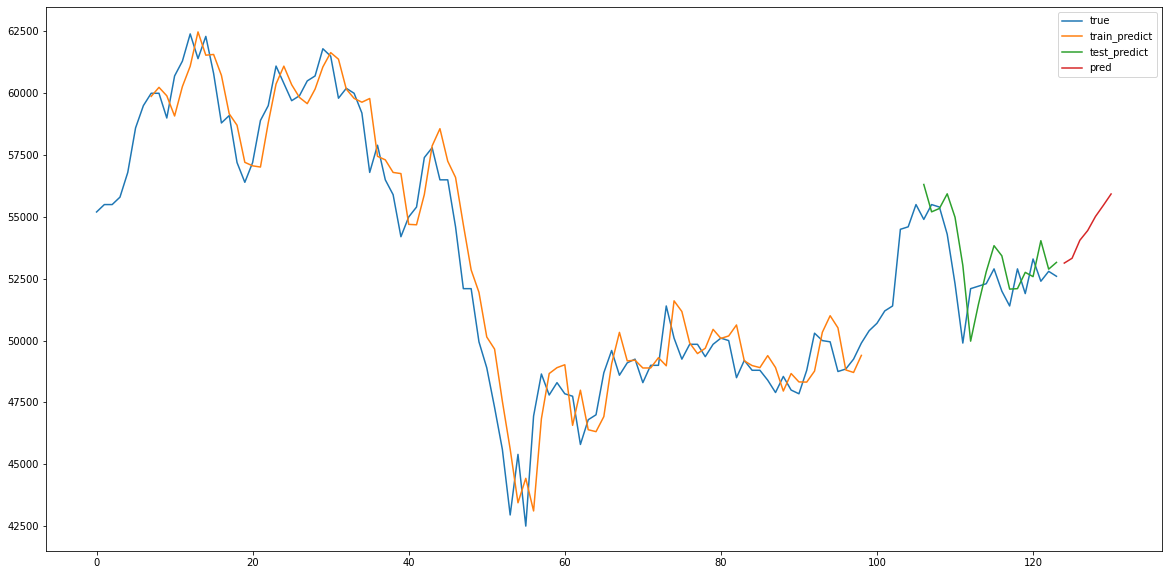



코드 진행시간(초) :  85.34237742424011
train_RMSE :  1287.5925633161298
test_RMSE :  1402.7797688966657


In [460]:
s = time.time()
train_RMSE, test_RMSE = rnn(code, start, end) # 함수 실행
e = time.time()

print()
print()

print('코드 진행시간(초) : ', e - s)
print('train_RMSE : ', train_RMSE)
print('test_RMSE : ', test_RMSE)

In [110]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [431]:
code = '005930.KS' # 사용자로부터 종목코드를 받음
start = '2020-01-01' # 
end='2020-12-31'

df = pdr.get_data_yahoo(code, start=start, end=end).reset_index()  # 주식 데이터 크롤링
dataset = df['Close'].values # 종가 데이터 추출
dataset = dataset.reshape(dataset.shape[0], 1) # 1차원배열을 2차원으로 변경
dataset = dataset.astype('float32') # int -> float변환
scaler = MinMaxScaler(feature_range=(0, 1)) 
Dataset = scaler.fit_transform(dataset) * 0.9 # Min-Max 변환 (최대값이 0.9가 되도록 * 0.9)
train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False) # 8:2로 tarin, test 분리

In [432]:
def create_dataset(dataset, look_back): # 종속변수와 독립변수를 생성하는 함수
  x_data = [] # 빈 리스트 생성
  y_data = []

  for i in range(len(dataset) - look_back):
    data = dataset[i: (i + look_back), 0]
    x_data.append(data)
    y_data.append(dataset[i + look_back, 0])
  return np.array(x_data), np.array(y_data)

In [433]:
look_back = 7
x_train, y_train = create_dataset(train_data, look_back) # train_data 생성
x_test, y_test = create_dataset(test_data, look_back) # test 데이터 생성

In [434]:
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [435]:
model = Sequential() # model 옵션
model.add(SimpleRNN(3, input_shape=(1, look_back)))
model.add(Dense(1, activation="linear"))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1) # train_data학습 

Epoch 1/100
191/191 [==============================] - 1s 4ms/step - loss: 0.1604
Epoch 2/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0152
Epoch 3/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 4/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0094
Epoch 5/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 6/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 7/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 8/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 9/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 10/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 11/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 12/100
191/191 [==============================] - 1s 4ms/step - loss: 0.0030
Epoch 13/100


In [436]:
trainPredict = model.predict(X_train) # train_data를 이용하여 예측
testPredict = model.predict(X_test) # test_data를 이용하여 예측
TrainPredict = scaler.inverse_transform(trainPredict / 0.9) # Min-Max변환된 값을 원래대로 되돌림
Y_train = scaler.inverse_transform([y_train / 0.9]) # Min-Max변환된 값을 원래대로 되돌림
TestPredict = scaler.inverse_transform(testPredict / 0.9) # Min-Max변환된 값을 원래대로 되돌림
Y_test = scaler.inverse_transform([y_test / 0.9]) # Min-Max변환된 값을 원래대로 되돌림

In [437]:
train_RMSE = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:, 0])) # train_RMSE
test_RMSE = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:, 0])) # test_RMSE

In [438]:
x_pred = np.zeros(look_back * look_back, dtype = float) # 예측값을 저장할 array생성
x_pred = x_pred.reshape(look_back, 1, look_back) # 3차원으로 변환

In [439]:
x_pred[0][0][:-1] = Dataset[-6:].reshape(6) # 최근 6일 데이터를 pred의 1번째 row, 1~6번째 인덱스에 저장
x_pred[0][0][-1] = model.predict(Dataset[-7:].reshape(1, 1, look_back)) # 최근 7일 데이터를 이용한 예측값을 pred의 1번째 row, 7번째 인덱스에 저장

In [440]:
for i in range(look_back):
  if i == 0:
    x_pred[0][0][:-1] = Dataset[-6:].reshape(6) # 최근 6일 데이터를 pred의 1번째 row, 1~6번째 인덱스에 저장
    x_pred[0][0][-1] = model.predict(Dataset[-7:].reshape(1, 1, look_back)) # 최근 7일 데이터를 이용한 예측값을 pred의 1번째 row, 7번째 인덱스에 저장
  elif i > 0:
    x_pred[i][0][:-1] = x_pred[i-1][0][1:] # pred의 이전 row의 2~7번째 데이터를 다음 row의 1~6번째 인덱스에 저장
    x_pred[i][0][-1] = model.predict(x_pred[[i-1]]) # pred의 이전 row의 1~7번째 데이터를 이용하여 데이터 예측 후, 다음 row의 7번재 인덱스에 저장

In [441]:
x_pred

array([[[0.69662333, 0.73402596, 0.82519466, 0.84623373, 0.83688307,
         0.89999998, 0.71386445]],

       [[0.73402596, 0.82519466, 0.84623373, 0.83688307, 0.89999998,
         0.71386445, 0.62790817]],

       [[0.82519466, 0.84623373, 0.83688307, 0.89999998, 0.71386445,
         0.62790817, 0.55647463]],

       [[0.84623373, 0.83688307, 0.89999998, 0.71386445, 0.62790817,
         0.55647463, 0.48905274]],

       [[0.83688307, 0.89999998, 0.71386445, 0.62790817, 0.55647463,
         0.48905274, 0.4718245 ]],

       [[0.89999998, 0.71386445, 0.62790817, 0.55647463, 0.48905274,
         0.4718245 , 0.45706674]],

       [[0.71386445, 0.62790817, 0.55647463, 0.48905274, 0.4718245 ,
         0.45706674, 0.43208542]]])

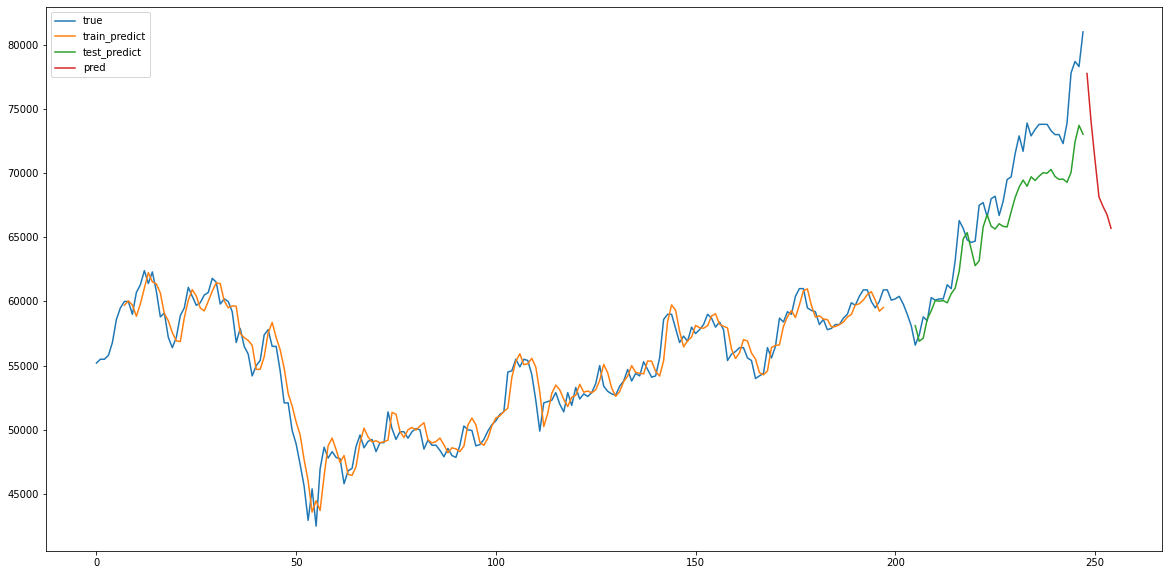

In [444]:
trainPredictPlot = np.zeros(len(dataset) + 7)
trainPredictPlot = trainPredictPlot.reshape(trainPredictPlot.shape[0], 1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(TrainPredict) + look_back] = TrainPredict
    
testPredictPlot = np.zeros(len(dataset) + 7)
testPredictPlot = testPredictPlot.reshape(testPredictPlot.shape[0], 1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(TrainPredict) + (look_back) * 2 : len(dataset) , :] = TestPredict

predPlot = np.zeros(len(dataset) + 7)
predPlot = predPlot.reshape(predPlot.shape[0], 1)
predPlot[:, :] = np.nan
predPlot[-7:] = x_pred[6].reshape(x_pred.shape[0], 1)
predPlot = scaler.inverse_transform(predPlot) / 0.9# Min-Max변환된 값을 원래대로 되돌림
    
plt.figure(figsize = (20, 10))
plt.plot(dataset, label = "true")
plt.plot(trainPredictPlot, label = 'train_predict')
plt.plot(testPredictPlot, label = 'test_predict')
plt.plot(predPlot, label = 'pred')
plt.legend()


plt.show()